In [1]:
from jupyter_core.version import parts
!pip install -r requirements.txt

In [9]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
def parse_car_meta(filename):
    parts = filename.split("_")

    year = parts[0]
    brand = parts[1]
    model =  parts[2] if len(parts) == 3 else "_".join(parts[2:])

    return year, brand, model


In [31]:
base_dir = './data/cars'

In [33]:
def read_file_content(file_path):
    """Read file content with encoding error handling."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
            return file.read()
    except UnicodeDecodeError:
        # Fallback to latin-1 if utf-8 fails
        with open(file_path, 'r', encoding='latin-1') as file:
            return file.read()

def extract_metadata(filename):
    """Extract and parse car metadata from soup."""
    return parse_car_meta(filename) if filename else ("Unknown", "Unknown", "Unknown") #

def process_review_document(doc, meta):
    """Process a single review document and extract its data."""
    date_tag = doc.find("date")
    author_tag = doc.find("author")
    text_tag = doc.find("text")
    favorite_tag = doc.find("favorite")

    date_str = date_tag.text if date_tag else None
    date = pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce') if date_str else None
    author = author_tag.text if author_tag else None
    text = text_tag.text if text_tag else None
    favorite = favorite_tag.text if favorite_tag else None

    return {
        "DATE": date,
        "AUTHOR": author,
        "TEXT": text,
        "FAVORITE": favorite,
        "MODEL": meta[2],
        "BRAND": meta[1],
        "YEAR_MADE": meta[0]  # Changed from "YEAR" to "YEAR_MADE"
    }

def parse_review_file(file_path):
    """Parse a review file and return a DataFrame of reviews."""
    file_content = read_file_content(file_path)

    soup = BeautifulSoup("<root>" + file_content + "</root>", 'html.parser')

    filename = os.path.basename(file_path)
    meta = extract_metadata(filename)
    docs = soup.find_all('doc')

    reviews = [process_review_document(doc, meta) for doc in docs]

    return pd.DataFrame(reviews)

In [34]:
def parse_all_reviews(base_dir='./data/cars'):
    """
    Parse all car reviews in the base directory structure.

    Args:
        base_dir (str): Base directory containing the car review files

    Returns:
        pd.DataFrame: Combined DataFrame with all reviews
    """
    dataframes = []
    total_files = 0
    total_errors = 0

    for year in os.listdir(base_dir):
        year_path = os.path.join(base_dir, year)

        if not os.path.isdir(year_path):
            continue

        print(f"Processing directory: {year}")

        for file_name in os.listdir(year_path):
            file_path = os.path.join(year_path, file_name)

            if not os.path.isfile(file_path):
                continue

            try:
                df = parse_review_file(file_path)
                dataframes.append(df)
                total_files += 1
                print(f"  Processed {file_path}: found {len(df)} reviews")

            except Exception as e:
                total_errors += 1
                print(f"  Error processing {file_path}: {str(e)}")

    if dataframes:
        # Filter out empty DataFrames before concatenation
        non_empty_dataframes = [df for df in dataframes if not df.empty]
        reviews_df = pd.concat(non_empty_dataframes, ignore_index=True)

        if df.empty:
            empty_df_count = len(dataframes) - len(non_empty_dataframes)
            print(df)
        else:
            empty_df_count = 0


        print(f"\nTotal files processed: {total_files}")
        print(f"Total files with errors: {total_errors}")
        print(f"Total empty dataframes: {empty_df_count}")
        print(f"Total reviews extracted: {len(reviews_df)}")

        return reviews_df
    else:
        print("No review data found.")
        return pd.DataFrame()

In [35]:

reviews_df = parse_all_reviews(base_dir)

print("\nReview Data Sample:")
print(reviews_df.head())

print("\nDataFrame Info:")
print(reviews_df.info())

print("\nSummary Statistics:")
print(reviews_df.describe(include='all'))

Processing directory: 2008
  Processed ./data/cars/2008/2008_bmw_x5: found 48 reviews
  Processed ./data/cars/2008/2008_gmc_yukon_hybrid: found 14 reviews
  Processed ./data/cars/2008/2008_chevrolet_suburban: found 25 reviews
  Processed ./data/cars/2008/2008_toyota_tacoma: found 83 reviews
  Processed ./data/cars/2008/2008_volvo_v70: found 11 reviews
  Processed ./data/cars/2008/2008_nissan_versa: found 120 reviews
  Processed ./data/cars/2008/2008_volvo_xc70: found 24 reviews
  Processed ./data/cars/2008/2008_honda_accord: found 540 reviews
  Processed ./data/cars/2008/2008_mercedes-benz_s-class: found 28 reviews
  Processed ./data/cars/2008/2008_toyota_highlander: found 188 reviews
  Processed ./data/cars/2008/2008_subaru_impreza: found 143 reviews
  Processed ./data/cars/2008/2008_dodge_nitro: found 44 reviews
  Processed ./data/cars/2008/2008_toyota_fj_cruiser: found 52 reviews
  Processed ./data/cars/2008/2008_chevrolet_uplander: found 13 reviews
  Processed ./data/cars/2008/2008

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/2936609093.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reviews_df = pd.concat(non_empty_dataframes, ignore_index=True)


In [36]:
reviews_df

,DATE,AUTHOR,TEXT,FAVORITE,MODEL,BRAND,YEAR_MADE
0,2009-05-12,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,x5,bmw,2008
1,2009-04-22,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,x5,bmw,2008
2,2009-04-13,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,x5,bmw,2008
3,2009-04-02,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,x5,bmw,2008
4,2009-03-27,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",x5,bmw,2008
...,...,...,...,...,...,...,...
42283,2009-03-15,NCjp,I have waited to write this for a few months b...,Has space but looks sporty at the same time. A...,spectra,kia,2009
42284,2009-03-12,mholly99,I waited 5 months to write this review because...,"The fuel economy is great, the car looks nice,...",spectra,kia,2009
42285,2008-12-26,JoshUNC,After comparing prices on the '07 to the new '...,The price. Warranty. Great gas mileage. Sporty.,spectra,kia,2009
42286,2008-10-30,Derail,My previous car was an 03 Focus. The Spectra i...,"The price. The zippy acceleration, yet I get 3...",spectra,kia,2009


In [37]:
def group_by_field(df, field, print_results=True):
    """
    Group reviews by the specified field and return the count for each group.

    Args:
        df (pd.DataFrame): DataFrame containing review data
        field (str): Field name to group by (e.g., 'YEAR', 'BRAND', 'MODEL', 'DATE')
        print_results (bool): Whether to print the results

    Returns:
        pd.Series: Count of reviews per group
    """
    if field not in df.columns:
        raise ValueError(f"Field '{field}' not found in DataFrame columns: {list(df.columns)}")

    counts = df.groupby(field).size()

    if print_results:
        print(f"Reviews per {field.lower()}:")
        print(counts)

    return counts

In [38]:
year_data = group_by_field(reviews_df, 'YEAR_MADE')
brand_data = group_by_field(reviews_df, 'BRAND')
model_data = group_by_field(reviews_df, 'MODEL')
date_data = group_by_field(reviews_df, 'DATE')

author_data = group_by_field(reviews_df, 'AUTHOR', print_results=True)

Reviews per year_made:
YEAR_MADE
2007    18903
2008    15438
2009     7947
dtype: int64
Reviews per brand:
BRAND
acura            1269
audi              637
bmw              1113
buick             504
cadillac          510
chevrolet        2864
chrysler          751
dodge            1682
ford             2775
gmc               831
honda            4570
hyundai          2502
infiniti          840
jeep             1189
kia               699
lexus             935
mazda            1819
mercedes-benz    1592
mini              196
mitsubishi        636
nissan           3003
pontiac          1086
saturn           1168
scion             700
smart             183
subaru           1015
suzuki            421
toyota           4720
volkswagen       1676
volvo             402
dtype: int64
Reviews per model:
MODEL
1_series         77
300              93
350z             58
370z             39
3_series        475
               ... 
yaris           589
yukon            98
yukon_hybrid     14
yukon_xl 

In [39]:
df = reviews_df
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[ \-]+", "_", regex=True)
      .str.replace(r"[^\w]", "", regex=True)
)

df

,date,author,text,favorite,model,brand,year_made
0,2009-05-12,Senor Oso,"This is a great car, performance with the spor...",Sport transmission and suspension along with 2...,x5,bmw,2008
1,2009-04-22,grizzy54,Since I bought this I've enjoyed it everyday. ...,Brakes dry automatically when it rains. Also h...,x5,bmw,2008
2,2009-04-13,City Engineer,"Bought brand new, June, 2008. Two months later...",Rear view camera,x5,bmw,2008
3,2009-04-02,Lt Dan,I'll make this blunt. I have had the car over ...,None of the features are WOW! For $65K I would...,x5,bmw,2008
4,2009-03-27,Jimmy,Bought X5 a year ago tomorrow and will be taki...,"Backup camera, voice recognition, comfortable ...",x5,bmw,2008
...,...,...,...,...,...,...,...
42283,2009-03-15,NCjp,I have waited to write this for a few months b...,Has space but looks sporty at the same time. A...,spectra,kia,2009
42284,2009-03-12,mholly99,I waited 5 months to write this review because...,"The fuel economy is great, the car looks nice,...",spectra,kia,2009
42285,2008-12-26,JoshUNC,After comparing prices on the '07 to the new '...,The price. Warranty. Great gas mileage. Sporty.,spectra,kia,2009
42286,2008-10-30,Derail,My previous car was an 03 Focus. The Spectra i...,"The price. The zippy acceleration, yet I get 3...",spectra,kia,2009


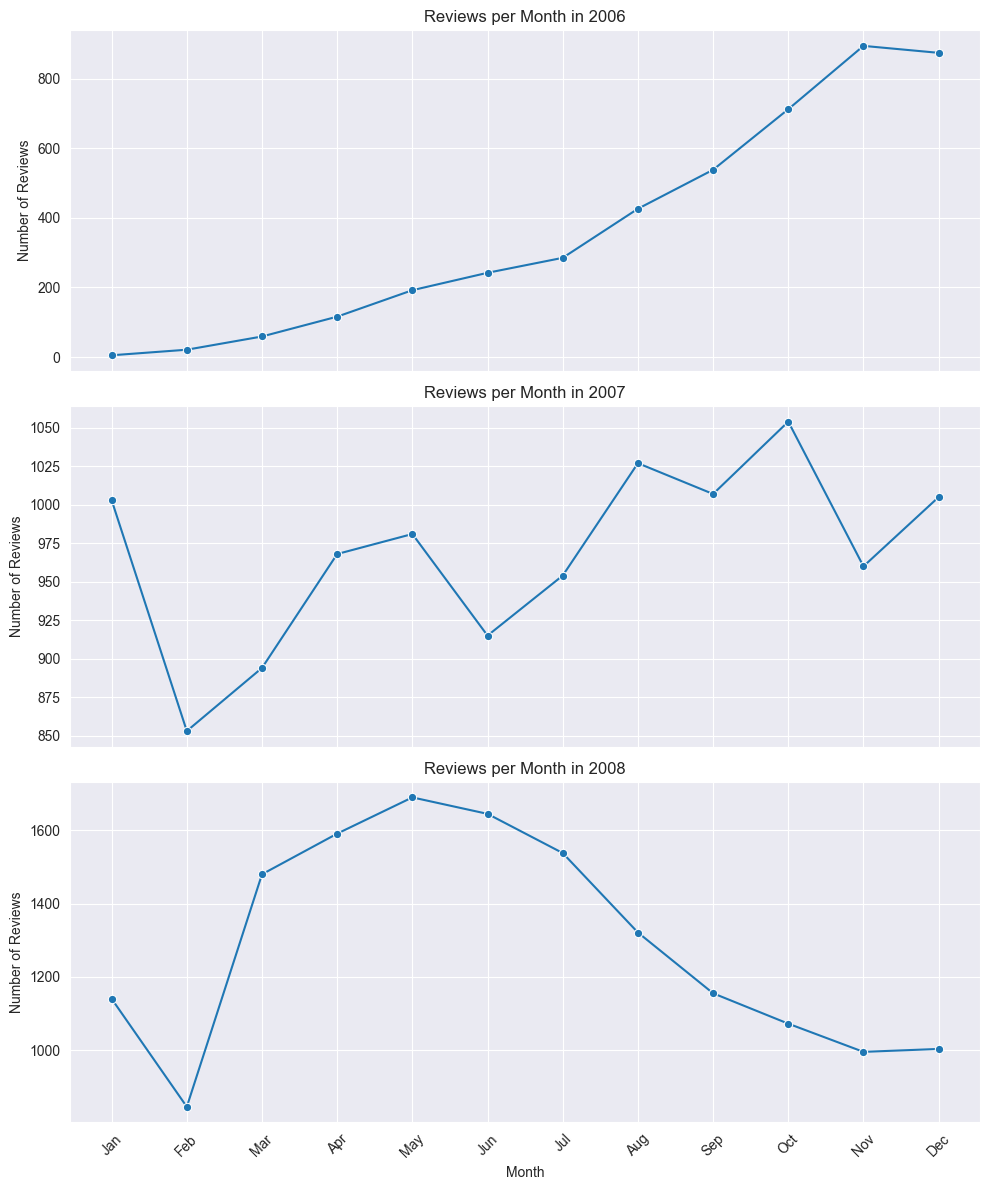

In [40]:


df['year_reviewed'] = df['date'].dt.year
df['month'] = df['date'].dt.month

counts = (
    df.groupby(['year_reviewed','month'])
      .size()
      .reset_index(name='n_reviews')
)

years = [2006, 2007, 2008, 2009, 2010] # изненадващо има ревюта и от 2006 - за коли от бъдещето...
fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(10, 12),
    sharex=True
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax, year in zip(axes, years):
    data = counts[counts['year_reviewed'] == year]
    sns.lineplot(
        data=data,
        x='month', y='n_reviews',
        marker='o',
        ax=ax
    )
    ax.set_title(f'Reviews per Month in {year}')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_names, rotation=45)
    ax.set_ylabel('Number of Reviews')

axes[-1].set_xlabel('Month')

plt.tight_layout()
plt.show()

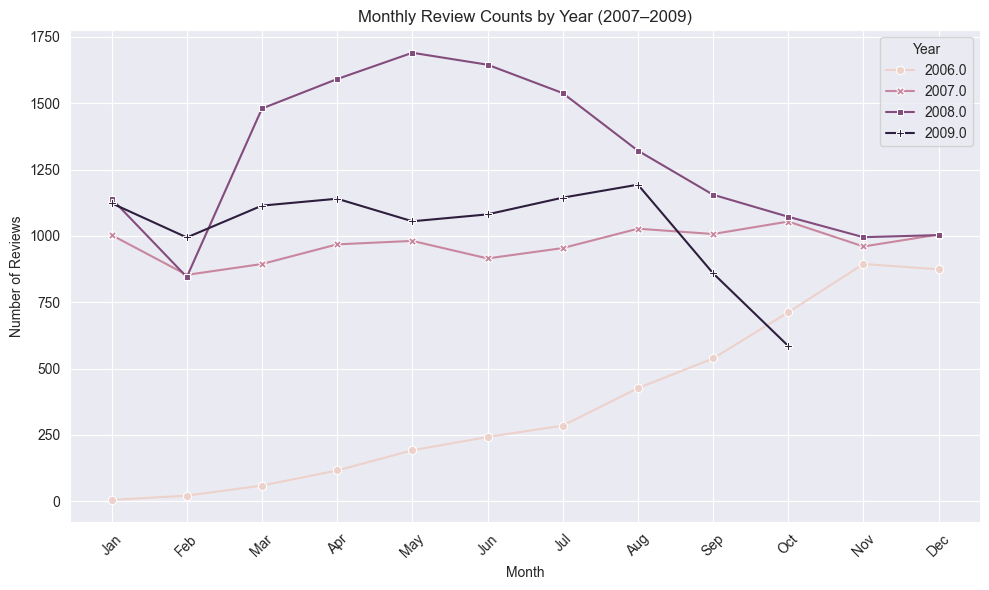

In [41]:

counts = (
    df.groupby(['year_reviewed','month'])  # Updated from 'year' to 'year_reviewed'
      .size()
      .reset_index(name='n_reviews')
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=counts,
    x='month', y='n_reviews',
    hue='year_reviewed',  # Updated from 'year' to 'year_reviewed'
    style='year_reviewed',  # Updated from 'year' to 'year_reviewed'
    markers=True,
    dashes=False
)

month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(ticks=range(1,13), labels=month_names, rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Review Counts by Year (2007–2009)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

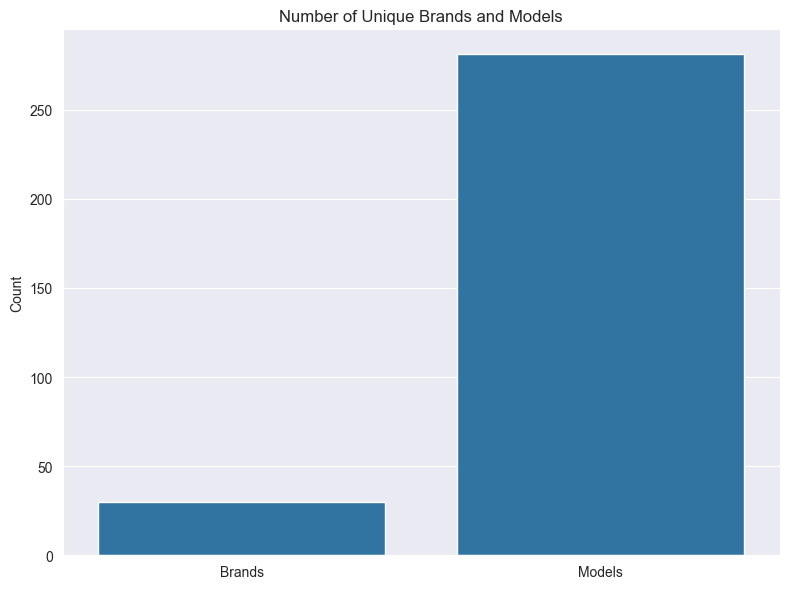

In [42]:
brand_count = df['brand'].nunique()
model_count = df['model'].nunique()

categories = ['Brands', 'Models']
counts = [brand_count, model_count]

plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=counts)
plt.title('Number of Unique Brands and Models')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

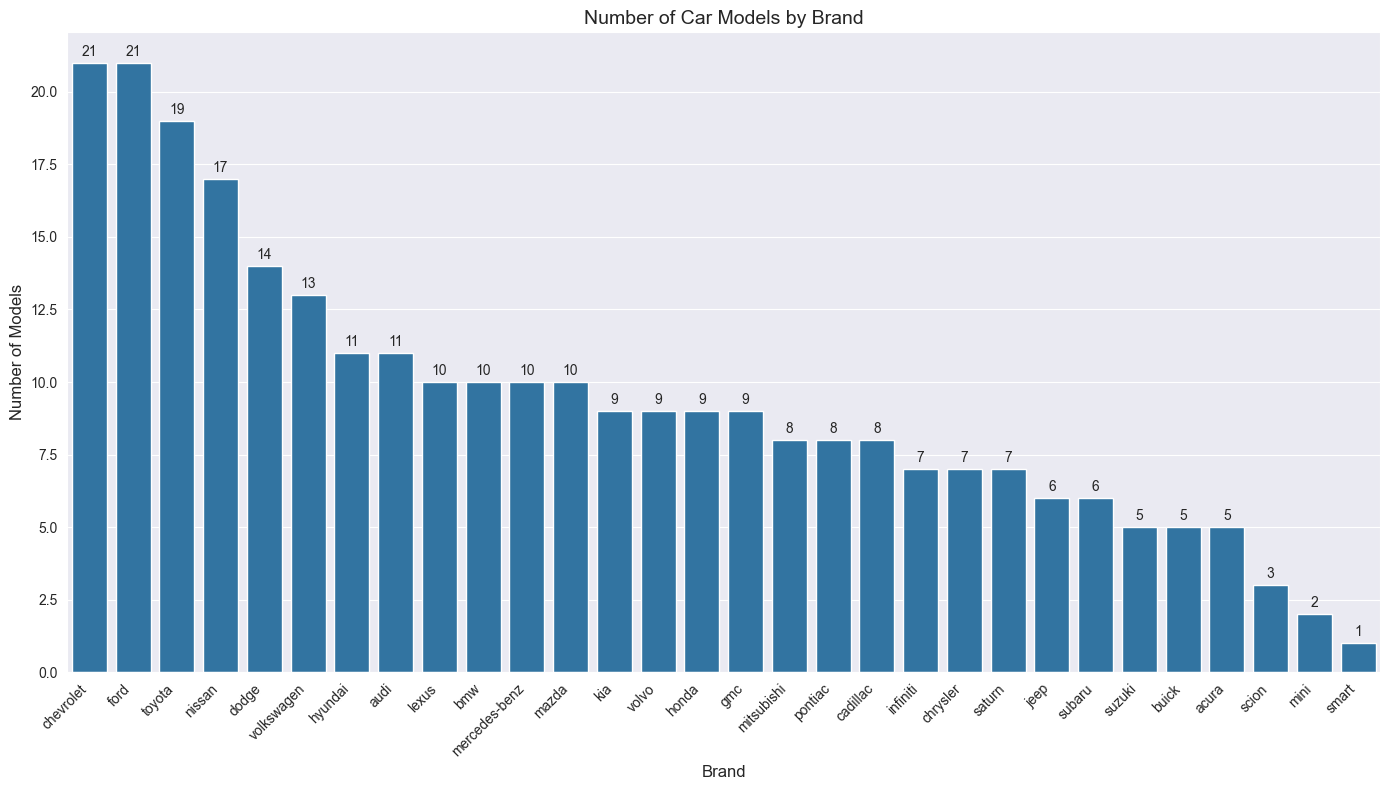

In [43]:
models_by_brand = df.groupby('brand')['model'].nunique().reset_index()
models_by_brand.columns = ['Brand', 'Number of Models']

models_by_brand = models_by_brand.sort_values('Number of Models', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=models_by_brand, x='Brand', y='Number of Models')

plt.title('Number of Car Models by Brand', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(ax.patches):
    count = models_by_brand.iloc[i]['Number of Models']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

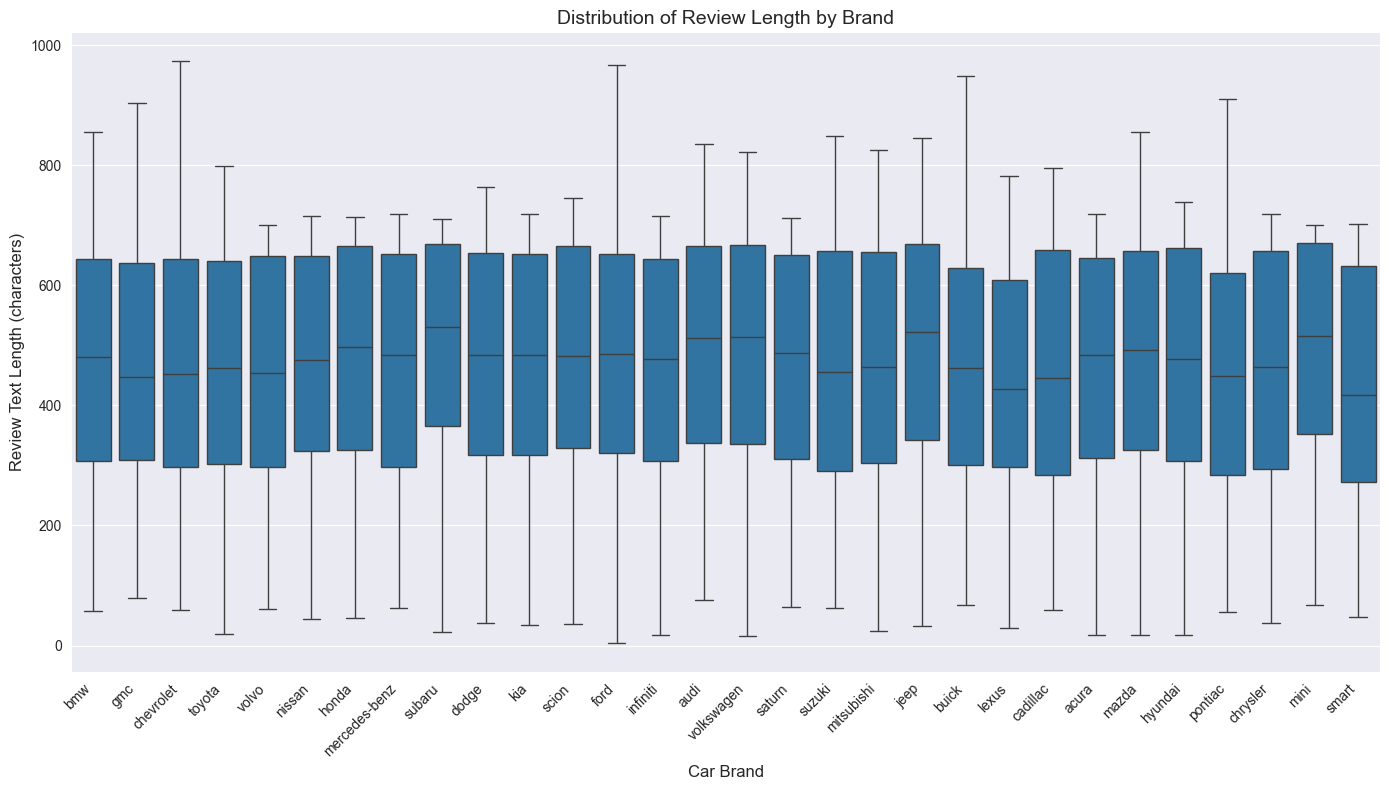

In [44]:
df['text_len'] = df['text'].str.len()

plt.figure(figsize=(14, 8))

ax = sns.boxplot(data=df, x='brand', y='text_len')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Car Brand', fontsize=12)
plt.ylabel('Review Text Length (characters)', fontsize=12)
plt.title("Distribution of Review Length by Brand", fontsize=14)

plt.subplots_adjust(bottom=0.2)

plt.tight_layout()

plt.show()

In [45]:
null_rows = df[df.isna().any(axis=1)]
print(f"Number of rows with null values: {len(null_rows)}")
display(null_rows)

empty_text_rows = df[(df['text'] == '') |
                     (df['author'] == '') |
                     (df['favorite'] == '')]
print(f"Number of rows with empty text fields: {len(empty_text_rows)}")
display(empty_text_rows)

Number of rows with null values: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
325,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
326,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
327,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
328,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
329,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
860,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
861,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
862,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
863,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Number of rows with empty text fields: 1631


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
41,2008-03-21,unhappy Jess,"Start with my X5 has only 3500 miles in it, at...",,x5,bmw,2008,2008.0,3.0,337.0
63,2009-07-09,DT,They just keep getting better. I had a Tahoe a...,,suburban,chevrolet,2008,2009.0,7.0,501.0
158,2007-12-10,retired_newmex,Fantastic truck. Lo-4 a little tricky to engag...,,tacoma,toyota,2008,2007.0,12.0,57.0
165,2007-09-28,jay,The best truck on the market. The ride is amaz...,,tacoma,toyota,2008,2007.0,9.0,354.0
185,2009-07-24,Hatchback,I expected more from a nissan. It has been in ...,,versa,nissan,2008,2009.0,7.0,382.0
...,...,...,...,...,...,...,...,...,...,...
42101,2009-04-18,sketchbone,Bought a black 1LT manual earlier today and I'...,,corvette,chevrolet,2009,2009.0,4.0,694.0
42117,2009-09-25,Becky,Love my new Murano! I got the S AWD with the c...,,murano,nissan,2009,2009.0,9.0,242.0
42222,2009-03-02,Lillie,I noticed in some old entries that Wind noise ...,,murano,nissan,2009,2009.0,3.0,337.0
42255,2008-09-16,goodday,Traded in a Quest van. Nissan really ramped up...,,murano,nissan,2009,2008.0,9.0,331.0


In [46]:
date_missing = df[df['date'].isna()]
print(f"Number of rows with missing dates: {len(date_missing)}")
display(date_missing)

df_filtered = df.dropna(subset=['date'])
print(f"Original dataframe shape: {df.shape}")
print(f"Filtered dataframe shape: {df_filtered.shape}")
print(f"Removed {df.shape[0] - df_filtered.shape[0]} rows with missing dates")

Number of rows with missing dates: 540


,date,author,text,favorite,model,brand,year_made,year_reviewed,month,text_len
325,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
326,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
327,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
328,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
329,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
860,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
861,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
862,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN
863,NaT,None,None,None,accord,honda,2008,NaN,NaN,NaN


Original dataframe shape: (42288, 10)
Filtered dataframe shape: (41748, 10)
Removed 540 rows with missing dates


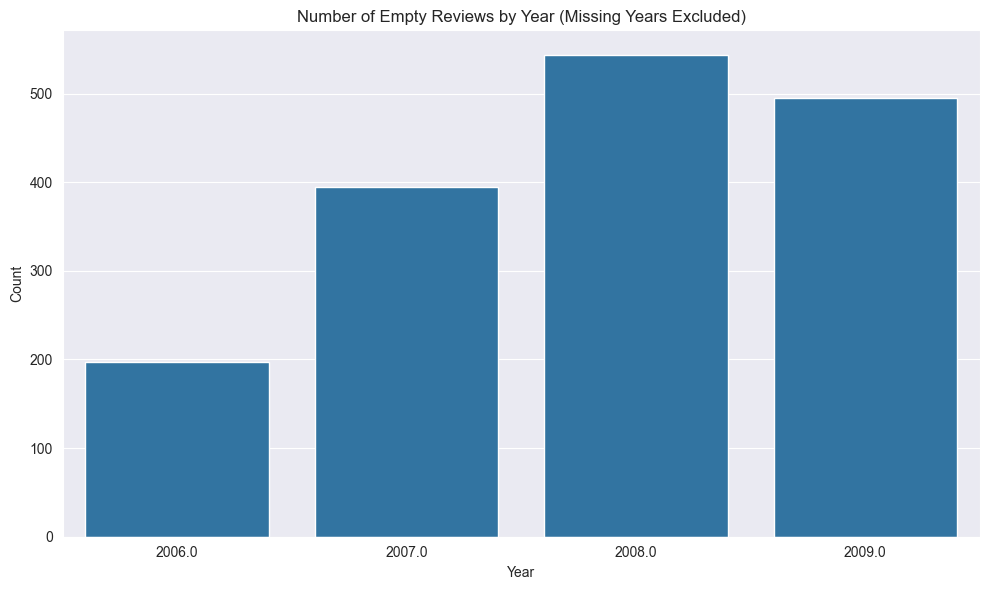

In [47]:
empty_reviews = df[(df.isna().any(axis=1)) |
                   (df['text'] == '') |
                   (df['author'] == '') |
                   (df['favorite'] == '')]

empty_reviews_filtered = empty_reviews.dropna(subset=['year_reviewed']).copy()

empty_by_year = empty_reviews_filtered.groupby('year_reviewed').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=empty_by_year, x='year_reviewed', y='count')
plt.title('Number of Empty Reviews by Year (Missing Years Excluded)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Average reviews per day: 31.04


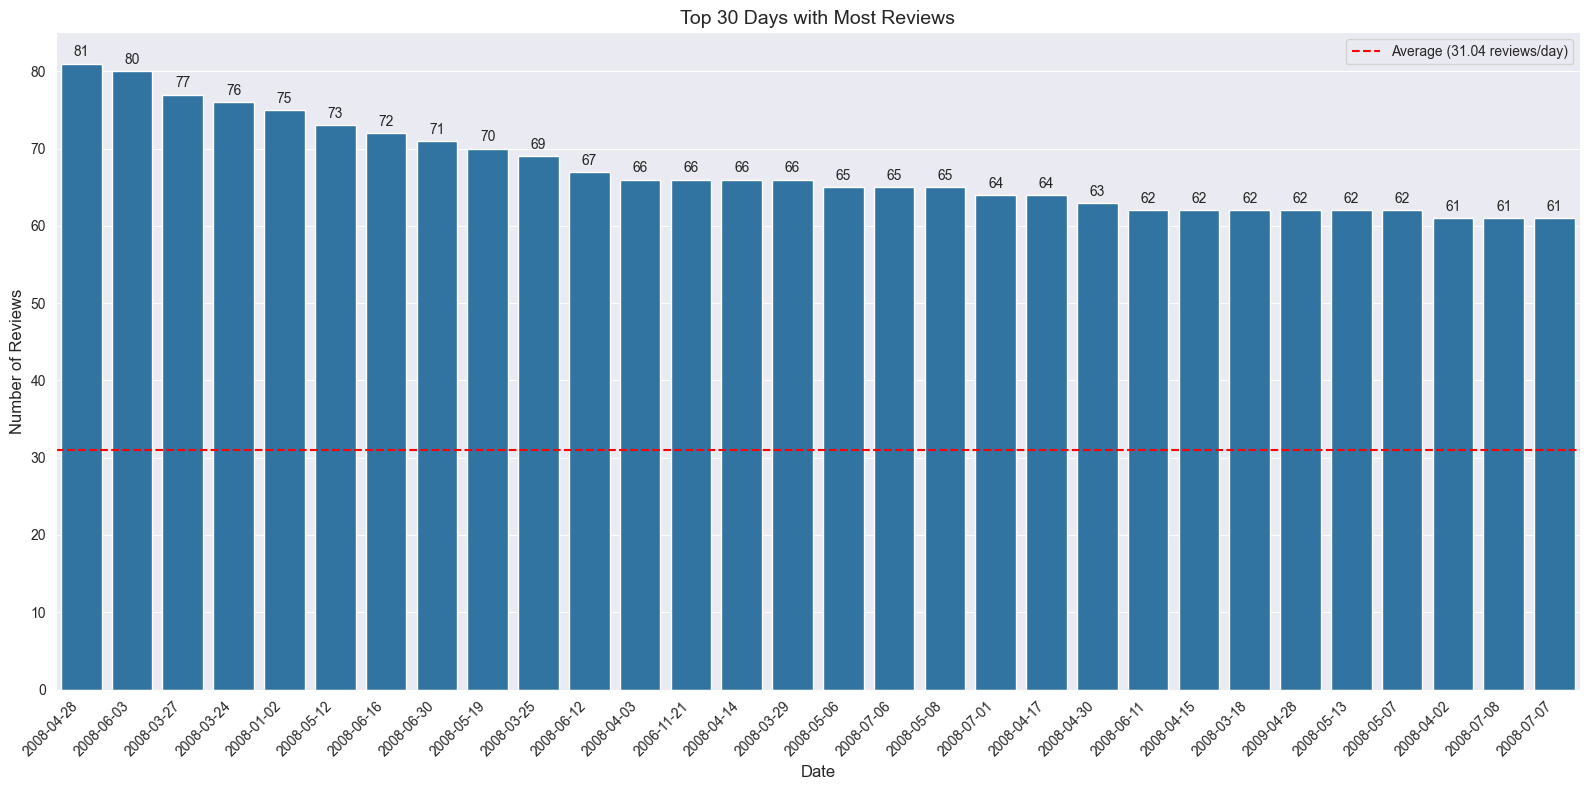

In [48]:
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

avg_reviews_per_day = reviews_per_day['reviews'].mean()
print(f"Average reviews per day: {avg_reviews_per_day:.2f}")


top_30_days = reviews_per_day.sort_values('reviews', ascending=False).head(30)

plt.figure(figsize=(16, 8))  # Larger figure to fit more bars
ax = sns.barplot(data=top_30_days, x='date', y='reviews')

ax.axhline(y=avg_reviews_per_day, color='r', linestyle='--',
           label=f'Average ({avg_reviews_per_day:.2f} reviews/day)')


plt.title('Top 30 Days with Most Reviews', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()

for i, bar in enumerate(ax.patches):
    count = top_30_days.iloc[i]['reviews']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

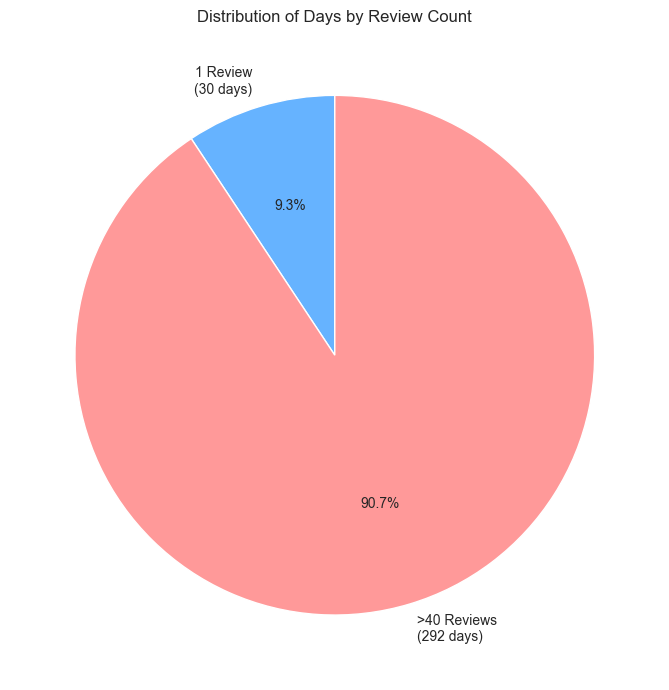

In [49]:

reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

days_with_1_review = (reviews_per_day['reviews'] == 1).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 40).sum()

categories = ['1 Review', '>40 Reviews']
counts = [days_with_1_review, days_with_over_40_reviews]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

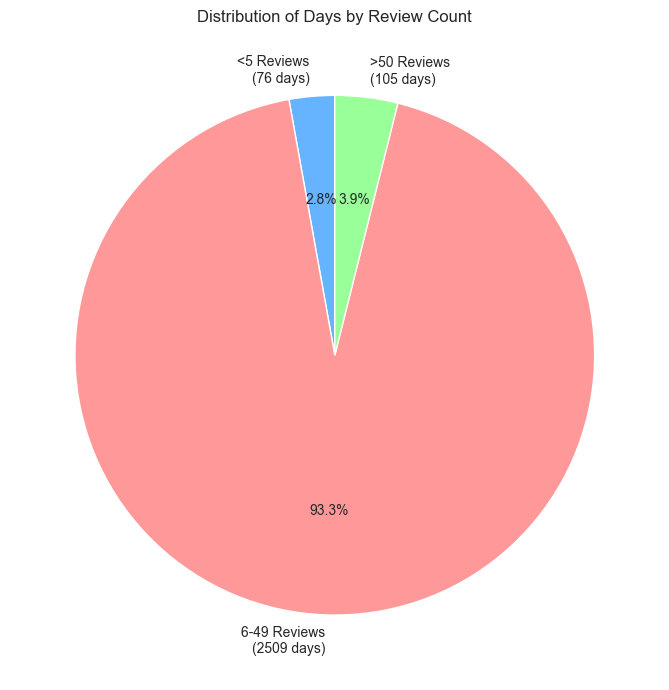

In [55]:

reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

days_with_1_review = (reviews_per_day['reviews'] < 5).sum()
days_in_between = (reviews_per_day['reviews'] >= 5).sum() + (reviews_per_day['reviews'] <= 50).sum()
days_with_over_40_reviews = (reviews_per_day['reviews'] > 50).sum()

categories = ['<5 Reviews', '6-49 Reviews', '>50 Reviews']
counts = [days_with_1_review, days_in_between, days_with_over_40_reviews]

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=[f"{cat}\n({cnt} days)" for cat, cnt in zip(categories, counts)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999', '#99ff99']
)
plt.title('Distribution of Days by Review Count')
plt.tight_layout()
plt.show()

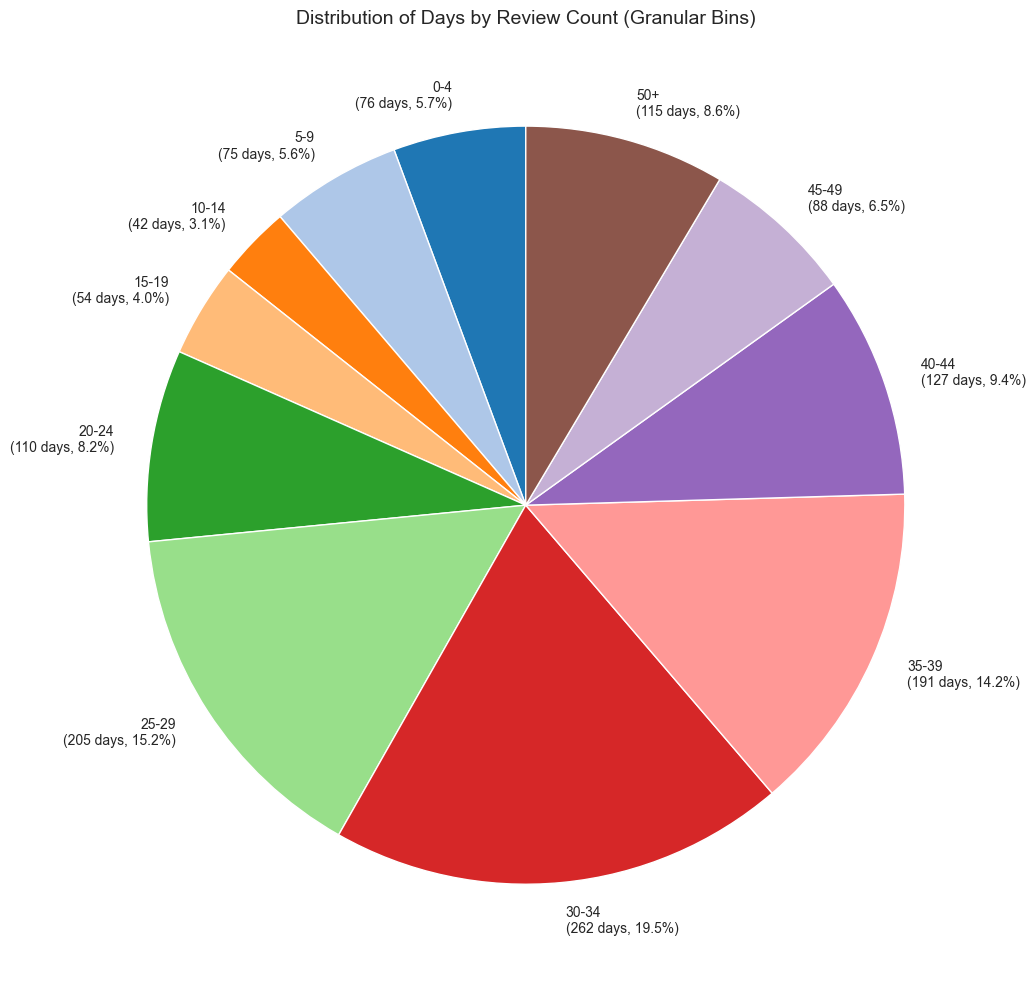

Distribution of days by review count:
0-4 reviews: 76 days (5.7%)
5-9 reviews: 75 days (5.6%)
10-14 reviews: 42 days (3.1%)
15-19 reviews: 54 days (4.0%)
20-24 reviews: 110 days (8.2%)
25-29 reviews: 205 days (15.2%)
30-34 reviews: 262 days (19.5%)
35-39 reviews: 191 days (14.2%)
40-44 reviews: 127 days (9.4%)
45-49 reviews: 88 days (6.5%)
50+ reviews: 115 days (8.6%)


In [56]:
reviews_per_day = df.groupby(df['date'].dt.date).size().reset_index(name='reviews')

bins = [0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49, float('inf')]
bin_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50+']

binned_reviews = pd.cut(reviews_per_day['reviews'], bins=bins, labels=bin_labels, right=True)
day_counts = binned_reviews.value_counts().sort_index()

pie_data = pd.DataFrame({'bin': day_counts.index, 'count': day_counts.values})

total_days = pie_data['count'].sum()
pie_data['percentage'] = (pie_data['count'] / total_days * 100).round(1)

pie_data['label'] = pie_data.apply(
    lambda x: f"{x['bin']}\n({x['count']} days, {x['percentage']}%)",
    axis=1
)

plt.figure(figsize=(12, 10))
plt.pie(
    pie_data['count'],
    labels=pie_data['label'],
    autopct='',  # Using custom labels instead
    startangle=90,
    colors=plt.cm.tab20.colors[:len(pie_data)]
)
plt.title('Distribution of Days by Review Count (Granular Bins)', fontsize=14)
plt.tight_layout()
plt.show()

# Display the actual counts in a table
print("Distribution of days by review count:")
for idx, row in pie_data.iterrows():
    print(f"{row['bin']} reviews: {row['count']} days ({row['percentage']}%)")


Top 6 brands by review count: ['toyota', 'honda', 'nissan', 'chevrolet', 'ford', 'hyundai']


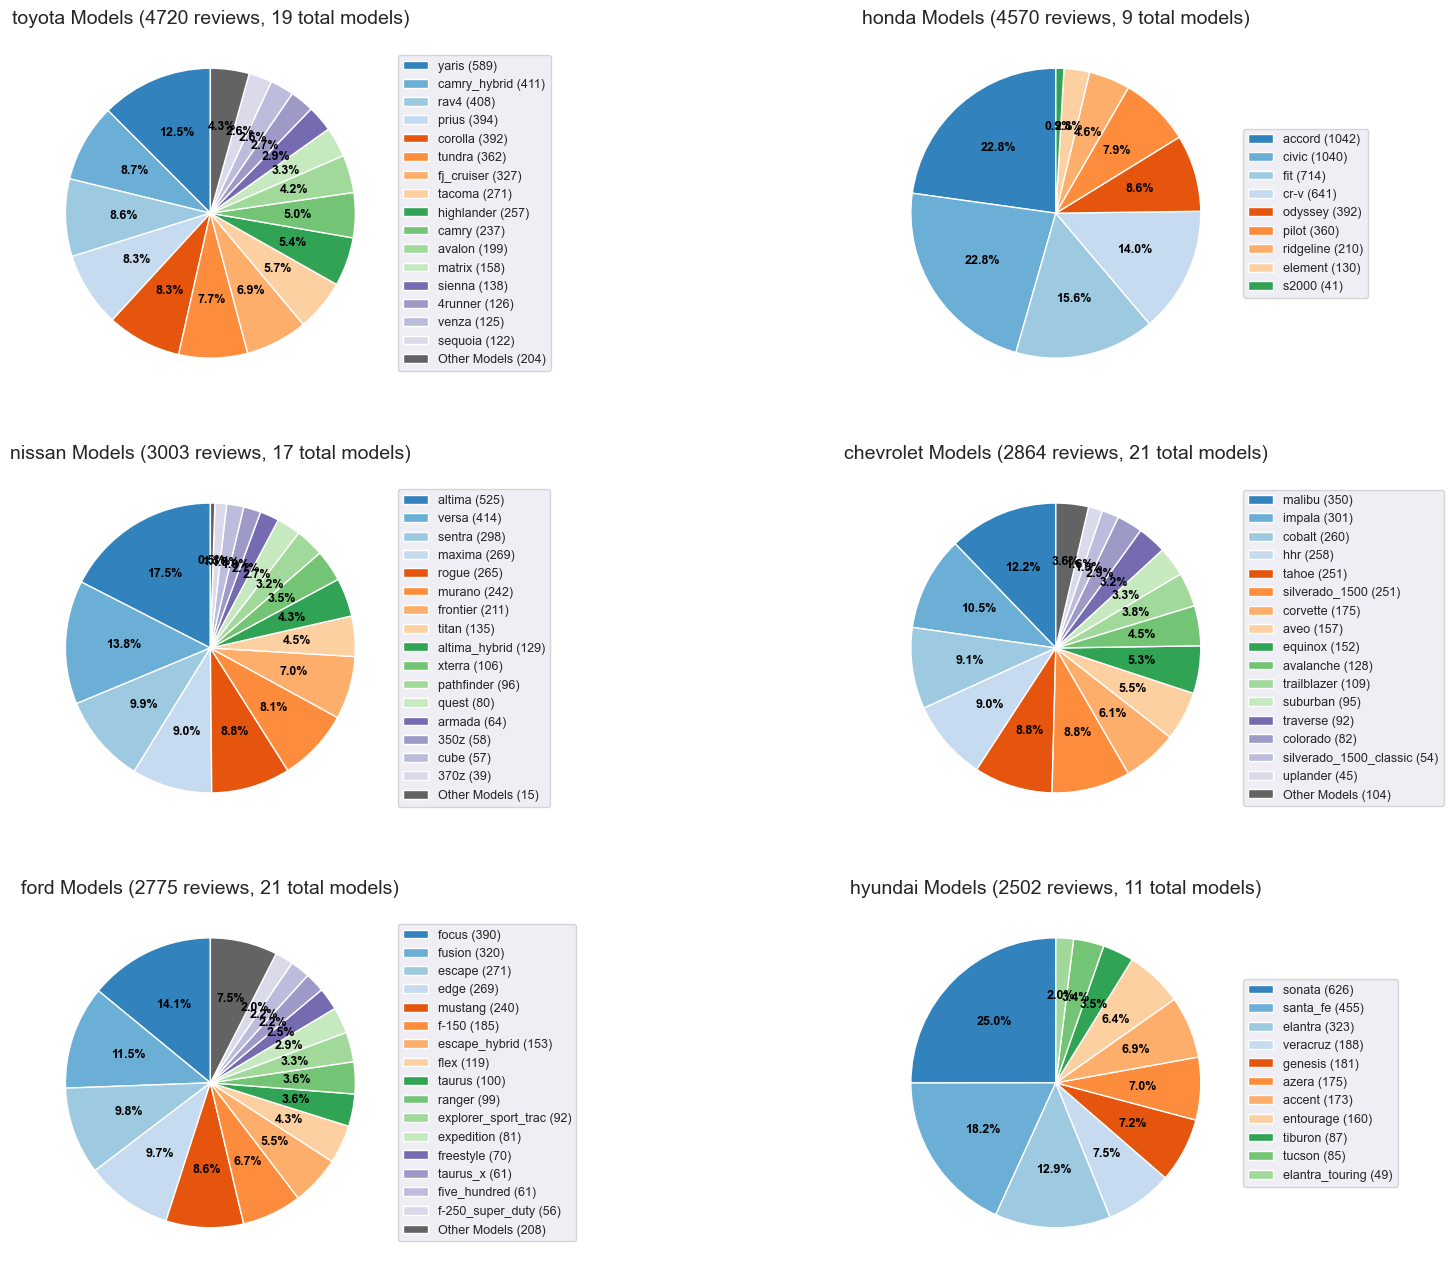

In [62]:
top_brands = df['brand'].value_counts().head(6).index.tolist()
print(f"Top 6 brands by review count: {top_brands}")

fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()  # Flatten for easier iteration

for i, brand in enumerate(top_brands):
    brand_data = df[df['brand'] == brand]

    model_counts = brand_data['model'].value_counts()
    total_reviews = model_counts.sum()
    num_models = len(model_counts)

    N = 16
    if len(model_counts) > N:
        top_models = model_counts.head(N)
        other_count = model_counts[N:].sum()
        plot_data = pd.concat([top_models, pd.Series({'Other Models': other_count})])
    else:
        plot_data = model_counts

    ax = axes[i]
    wedges, texts, autotexts = ax.pie(
        plot_data.values,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab20c.colors[:len(plot_data)],
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)

    ax.set_title(f'{brand} Models ({total_reviews} reviews, {num_models} total models)', fontsize=14)

    legend_labels = [f"{model} ({count})" for model, count in zip(plot_data.index, plot_data.values)]
    ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

plt.show()


In [51]:

unique_favorites_count = df['favorite'].nunique()
print(f"Number of unique favorites: {unique_favorites_count}")

favorite_counts = df['favorite'].value_counts().reset_index()
favorite_counts.columns = ['Favorite', 'Count']

print("\nTop favorites and their counts:")
display(favorite_counts.head(10))  # Show top 10 favorites

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=favorite_counts.head(15), x='Favorite', y='Count')
plt.title('Most Common Favorites', fontsize=14)
plt.xlabel('Favorite', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, bar in enumerate(ax.patches):
    count = favorite_counts.iloc[i]['Count']
    ax.annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

Number of unique favorites: 38571

Top favorites and their counts:


TypeError: display() missing 1 required positional argument: 'text'

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/377681255.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/377681255.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')


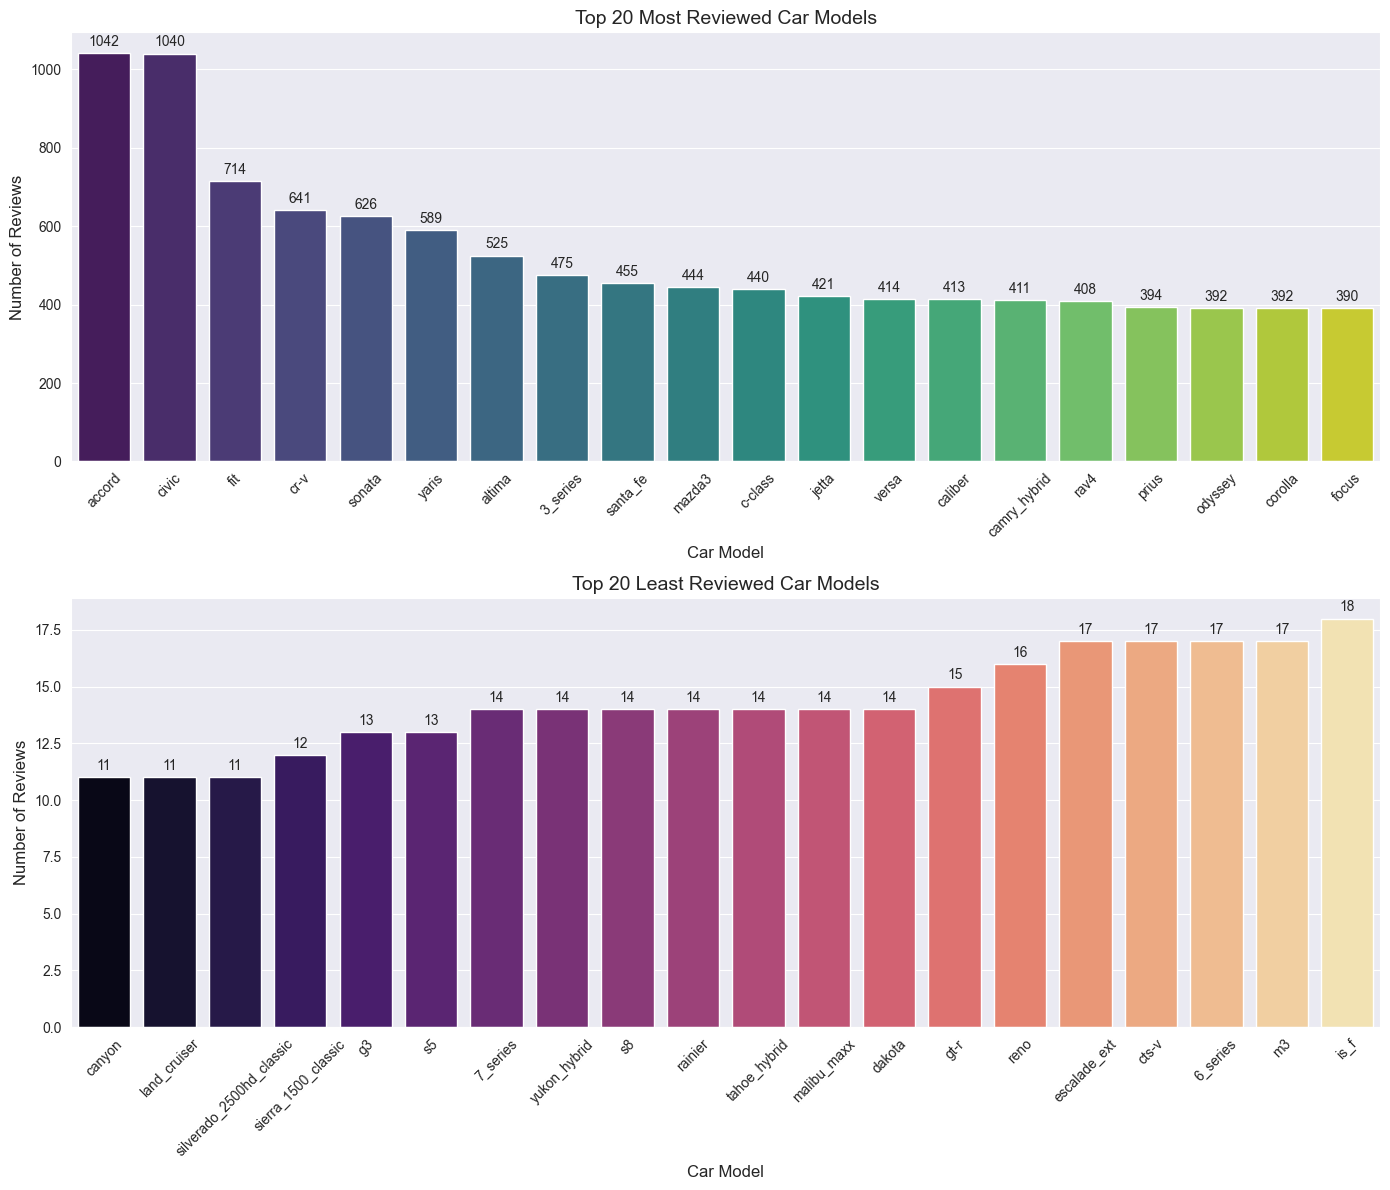

In [52]:
model_review_counts = df.groupby('model').size().reset_index(name='count')

most_reviewed = model_review_counts.sort_values('count', ascending=False).head(20)
least_reviewed = model_review_counts.sort_values('count').head(20)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

sns.barplot(data=most_reviewed, x='model', y='count', ax=axes[0], palette='viridis')
axes[0].set_title('Top 20 Most Reviewed Car Models', fontsize=14)
axes[0].set_xlabel('Car Model', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

for i, bar in enumerate(axes[0].patches):
    count = most_reviewed.iloc[i]['count']
    axes[0].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

sns.barplot(data=least_reviewed, x='model', y='count', ax=axes[1], palette='magma')
axes[1].set_title('Top 20 Least Reviewed Car Models', fontsize=14)
axes[1].set_xlabel('Car Model', fontsize=12)
axes[1].set_ylabel('Number of Reviews', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

for i, bar in enumerate(axes[1].patches):
    count = least_reviewed.iloc[i]['count']
    axes[1].annotate(f'{count}',
                xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [99]:
model_counts = df.groupby('model').size().sort_values(ascending=False)
print("Unique Car Models with Review Counts:")
print("====================================")
for model, count in model_counts.items():
    print(f"{model}: {count}")

print(f"\nTotal unique models: {len(model_counts)}")

Unique Car Models with Review Counts:
accord: 1042
civic: 1040
camry: 731
fit: 714
altima: 654
cr-v: 641
sonata: 626
yaris: 589
grand: 486
3: 475
santa: 455
mazda3: 444
c-class: 440
escape: 424
jetta: 421
versa: 414
caliber: 413
rav4: 408
prius: 394
corolla: 392
odyssey: 392
focus: 390
acadia: 388
elantra: 372
tl: 371
highlander: 367
malibu: 364
tundra: 362
pilot: 360
silverado: 357
aura: 331
cx-7: 331
wrangler: 327
fj: 327
vue: 325
g35: 320
fusion: 320
ram: 318
mdx: 315
impala: 301
sentra: 298
g6: 286
xb: 275
tacoma: 271
edge: 269
maxima: 269
patriot: 267
tsx: 266
cx-9: 265
rogue: 265
tahoe: 265
impreza: 265
rdx: 263
forester: 260
cobalt: 260
enclave: 259
passat: 259
mazda6: 258
hhr: 258
is: 247
rabbit: 242
e-class: 242
murano: 242
mustang: 240
5: 239
g8: 236
tc: 232
es: 226
sierra: 224
a4: 223
outlander: 222
m-class: 222
cts: 219
gl-class: 214
frontier: 211
ridgeline: 210
town: 207
outlook: 206
rx: 203
avalon: 199
outback: 198
cooper: 196
xd: 193
mazda5: 191
veracruz: 188
nitro: 187


In [64]:
import re
import nltk
import string
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
vader = SentimentIntensityAnalyzer()


def clean_text(text):
    """Clean and normalize text data."""
    if not isinstance(text, str) or pd.isna(text):
        return ""

    text = text.lower()

    text = re.sub(r'<.*?>', '', text)

    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text


def preprocess_text(text):
    """Tokenize, remove stopwords, and lemmatize text."""
    if not text:
        return []

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


def extract_features(row):
    """Extract features from text fields."""
    text = clean_text(row['text']) if isinstance(row['text'], str) else ""
    favorite = clean_text(row['favorite']) if isinstance(row['favorite'], str) else ""

    text_length = len(text)
    text_word_count = len(text.split()) if text else 0

    processed_tokens = preprocess_text(text)

    vader_scores = vader.polarity_scores(text) if text else {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

    tb = TextBlob(text)
    tb_polarity = tb.sentiment.polarity if text else 0
    tb_subjectivity = tb.sentiment.subjectivity if text else 0

    has_price_mention = 1 if re.search(r'price|cost|expensive|cheap|afford', text) else 0
    has_performance_mention = 1 if re.search(r'speed|fast|slow|acceleration|horsepower|hp|mpg', text) else 0
    has_comfort_mention = 1 if re.search(r'comfort|seat|space|room|leg|interior', text) else 0
    has_reliability_mention = 1 if re.search(r'reliable|dependable|quality|problem|issue|break', text) else 0

    return {
        'text_length': text_length,
        'word_count': text_word_count,
        'vader_negative': vader_scores['neg'],
        'vader_neutral': vader_scores['neu'],
        'vader_positive': vader_scores['pos'],
        'vader_compound': vader_scores['compound'],
        'textblob_polarity': tb_polarity,
        'textblob_subjectivity': tb_subjectivity,
        'has_price_mention': has_price_mention,
        'has_performance_mention': has_performance_mention,
        'has_comfort_mention': has_comfort_mention,
        'has_reliability_mention': has_reliability_mention,
        'cleaned_text': ' '.join(processed_tokens)
    }

[nltk_data] Downloading package punkt to /Users/tsvetan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tsvetan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tsvetan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Enriched DataFrame with text features:

Sentiment Analysis Statistics:
       vader_compound  textblob_polarity  textblob_subjectivity
count    42288.000000       42288.000000           42288.000000
mean         0.697473           0.240383               0.524715
std          0.476069           0.174218               0.133011
min         -0.992000          -1.000000               0.000000
25%          0.717200           0.137396               0.454859
50%          0.911700           0.243242               0.528175
75%          0.963200           0.345844               0.602246
max          0.997700           1.000000               1.000000


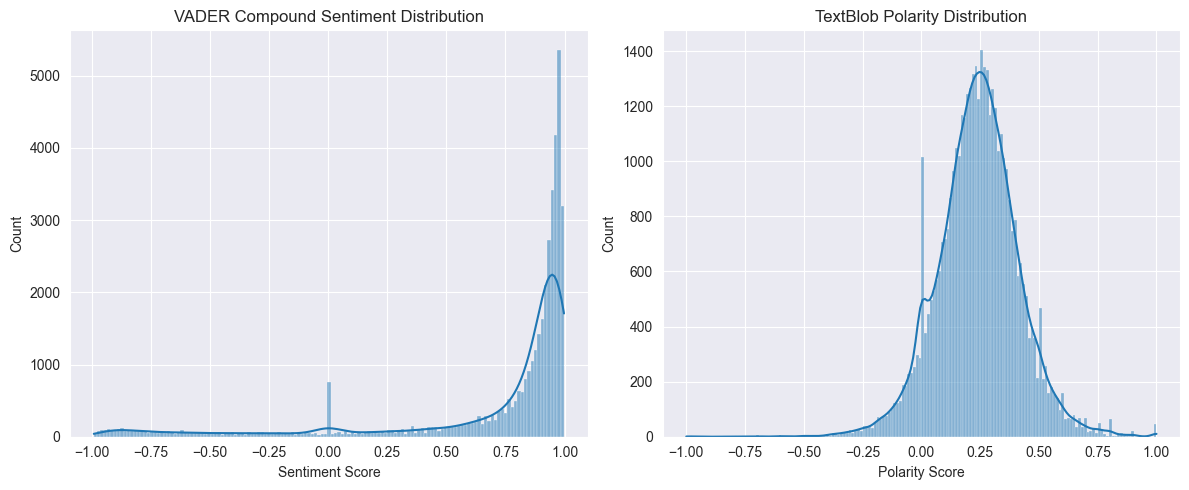

In [65]:
feature_data = df.apply(extract_features, axis=1)

features_df = pd.DataFrame(feature_data.tolist())

df_enriched = pd.concat([df, features_df], axis=1)

print("Enriched DataFrame with text features:")
var = df_enriched.sample(5)[['model', 'brand', 'text_length', 'word_count',
                             'vader_compound', 'textblob_polarity', 'has_performance_mention']]

print("\nSentiment Analysis Statistics:")
print(df_enriched[['vader_compound', 'textblob_polarity', 'textblob_subjectivity']].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_enriched['vader_compound'], kde=True)
plt.title('VADER Compound Sentiment Distribution')
plt.xlabel('Sentiment Score')

plt.subplot(1, 2, 2)
sns.histplot(df_enriched['textblob_polarity'], kde=True)
plt.title('TextBlob Polarity Distribution')
plt.xlabel('Polarity Score')

plt.tight_layout()
plt.show()

Distribution of sentiment labels:
sentiment_label
positive    37065
negative     3867
neutral      1356
Name: count, dtype: int64


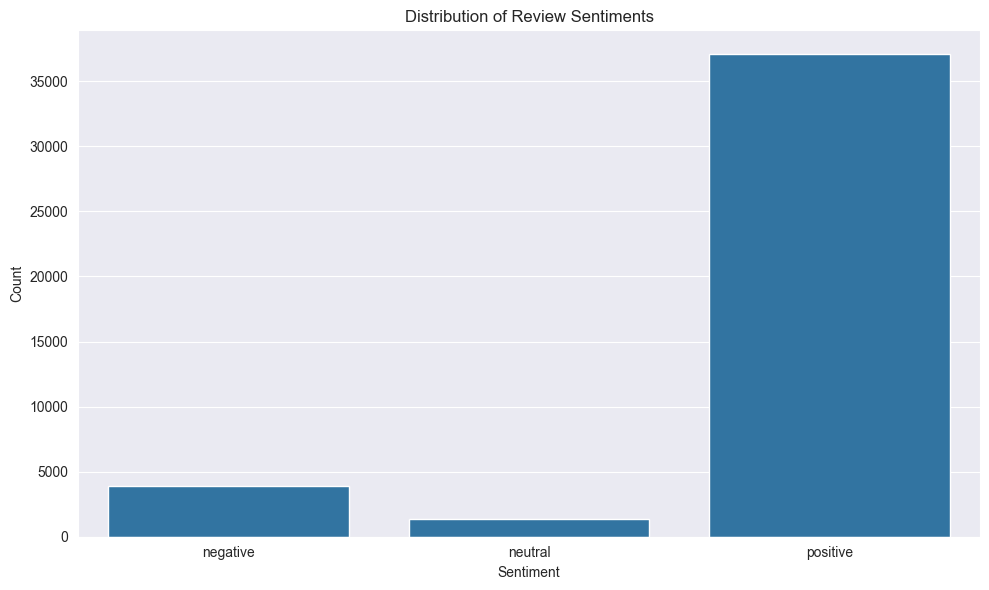

Training set size: 33398
Testing set size: 8350


In [66]:
# Implement Bag of Words + Naive Bayes for sentiment classification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np

# First, let's create sentiment labels based on the vader_compound score
# This is a common approach for creating discrete sentiment classes
df_enriched['sentiment_label'] = pd.cut(
    df_enriched['vader_compound'],
    bins=[-1, -0.1, 0.1, 1],
    labels=['negative', 'neutral', 'positive']
)

# Check the distribution of sentiment labels
sentiment_distribution = df_enriched['sentiment_label'].value_counts()
print("Distribution of sentiment labels:")
print(sentiment_distribution)

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=df_enriched)
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Prepare data for classification
# We'll use cleaned_text which was already preprocessed
X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label']

# Remove rows with empty text or NaN values
valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


In [ ]:
# Create a pipeline with Bag of Words and Naive Bayes
# First approach: Simple CountVectorizer
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
])

# Train the model
bow_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = bow_pipeline.predict(X_test)

# Evaluate the model
print("\nBag of Words + Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Bag of Words + Naive Bayes')
plt.tight_layout()
plt.show()



TF-IDF + Naive Bayes Results:
Accuracy: 0.9126946107784432

Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.41      0.52       774
     neutral       0.00      0.00      0.00       163
    positive       0.92      0.98      0.95      7413

    accuracy                           0.91      8350
   macro avg       0.54      0.47      0.49      8350
weighted avg       0.89      0.91      0.90      8350



/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

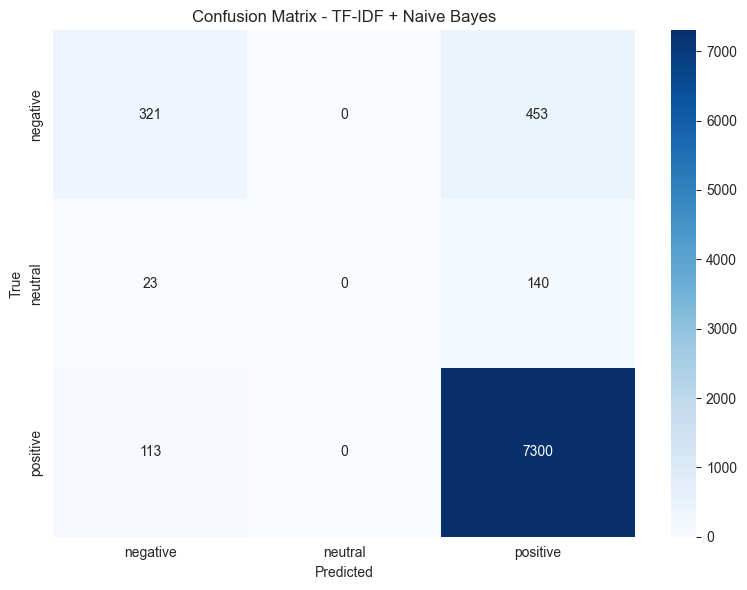

In [67]:
# Let's try a more advanced approach: TF-IDF + Naive Bayes with n-grams
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),  # Include both unigrams and bigrams
        min_df=5  # Minimum document frequency
    )),
    ('classifier', MultinomialNB())
])

# Train the model
tfidf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_tfidf = tfidf_pipeline.predict(X_test)

# Evaluate the model
print("\nTF-IDF + Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

# Display confusion matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TF-IDF + Naive Bayes')
plt.tight_layout()
plt.show()


In [76]:
# Implementing Logistic Regression with Bag of Words and TF-IDF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

print("Implementing Logistic Regression models and comparing with Naive Bayes...")

# Ensure we're using the same data as before
X = df_enriched['cleaned_text']
y = df_enriched['sentiment_label']

# Remove rows with empty text or NaN values
valid_indices = ~X.isna() & (X != '')
X = X[valid_indices]
y = y[valid_indices]

# Use the same train/test split for fair comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a results dictionary to store performance metrics
model_results = {}


Implementing Logistic Regression models and comparing with Naive Bayes...



1. Training Bag of Words + Logistic Regression...


/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training completed in 1.27 seconds

Bag of Words + Logistic Regression Results:
Accuracy: 0.9316

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.70      0.71       774
     neutral       0.10      0.02      0.04       163
    positive       0.95      0.98      0.97      7413

    accuracy                           0.93      8350
   macro avg       0.60      0.57      0.57      8350
weighted avg       0.92      0.93      0.92      8350



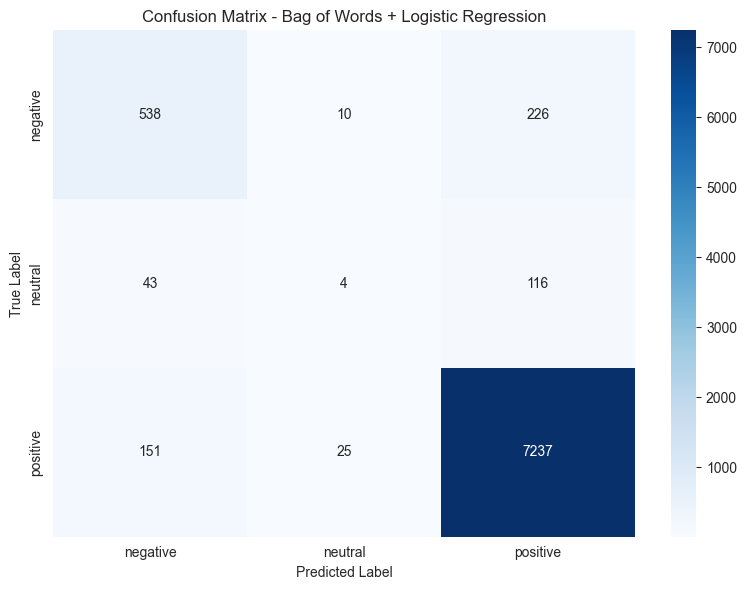

In [77]:
# 1. Bag of Words + Logistic Regression
print("\n1. Training Bag of Words + Logistic Regression...")
start_time = time.time()

bow_lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr'))
])

bow_lr_pipeline.fit(X_train, y_train)
y_pred_bow_lr = bow_lr_pipeline.predict(X_test)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_bow_lr)
report = classification_report(y_test, y_pred_bow_lr, output_dict=True)
cm = confusion_matrix(y_test, y_pred_bow_lr)

print("\nBag of Words + Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow_lr))

# Store results
model_results['BOW + LR'] = {
    'accuracy': accuracy,
    'report': report,
    'confusion_matrix': cm,
    'training_time': train_time
}

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Bag of Words + Logistic Regression')
plt.tight_layout()
plt.show()



2. Training TF-IDF + Logistic Regression...


/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training completed in 2.40 seconds

TF-IDF + Logistic Regression Results:
Accuracy: 0.9284

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.53      0.64       774
     neutral       0.00      0.00      0.00       163
    positive       0.94      0.99      0.96      7413

    accuracy                           0.93      8350
   macro avg       0.58      0.51      0.54      8350
weighted avg       0.91      0.93      0.91      8350



/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

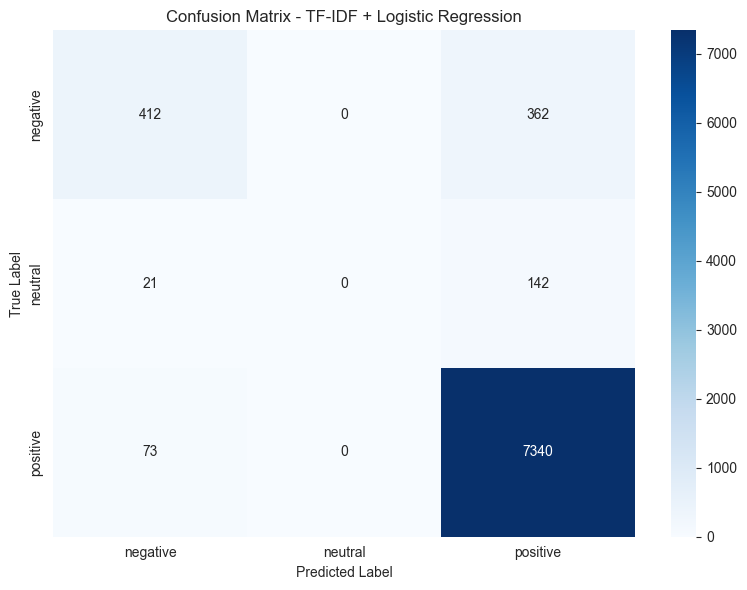

In [78]:
# 2. TF-IDF + Logistic Regression
print("\n2. Training TF-IDF + Logistic Regression...")
start_time = time.time()

tfidf_lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr'))
])

tfidf_lr_pipeline.fit(X_train, y_train)
y_pred_tfidf_lr = tfidf_lr_pipeline.predict(X_test)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_tfidf_lr)
report = classification_report(y_test, y_pred_tfidf_lr, output_dict=True)
cm = confusion_matrix(y_test, y_pred_tfidf_lr)

print("\nTF-IDF + Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf_lr))

# Store results
model_results['TF-IDF + LR'] = {
    'accuracy': accuracy,
    'report': report,
    'confusion_matrix': cm,
    'training_time': train_time
}

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - TF-IDF + Logistic Regression')
plt.tight_layout()
plt.show()


In [79]:
# Collect results for the Naive Bayes models (if you've run them already)
# For BOW + NB
if 'bow_pipeline' in locals():
    start_time = time.time()
    bow_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred_bow_nb = bow_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_bow_nb)
    report = classification_report(y_test, y_pred_bow_nb, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_bow_nb)

    model_results['BOW + NB'] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': train_time
    }

# For TF-IDF + NB
if 'tfidf_pipeline' in locals():
    start_time = time.time()
    tfidf_pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred_tfidf_nb = tfidf_pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_tfidf_nb)
    report = classification_report(y_test, y_pred_tfidf_nb, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_tfidf_nb)

    model_results['TF-IDF + NB'] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': train_time
    }

# Also collect results for the optimized TF-IDF + NB if available
if 'tfidf_nb_model' in locals():
    model_name = 'TF-IDF + NB (Optimized)'
    start_time = time.time()
    # Use the pre-trained model if available
    y_pred = tfidf_nb_model.predict(X_test)
    predict_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    model_results[model_name] = {
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'prediction_time': predict_time
    }


/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tsvetan/fmi/deep_learning/propro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p


Model Performance Comparison:
                     Model  Accuracy  F1 Score (weighted)  Training Time (s)
0                 BOW + LR  0.931617             0.924111           1.265819
1              TF-IDF + LR  0.928383             0.913882           2.403554
3  TF-IDF + NB (Optimized)  0.915928             0.902673           0.000000
2              TF-IDF + NB  0.912695             0.895178           1.973705


/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/1344807246.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')


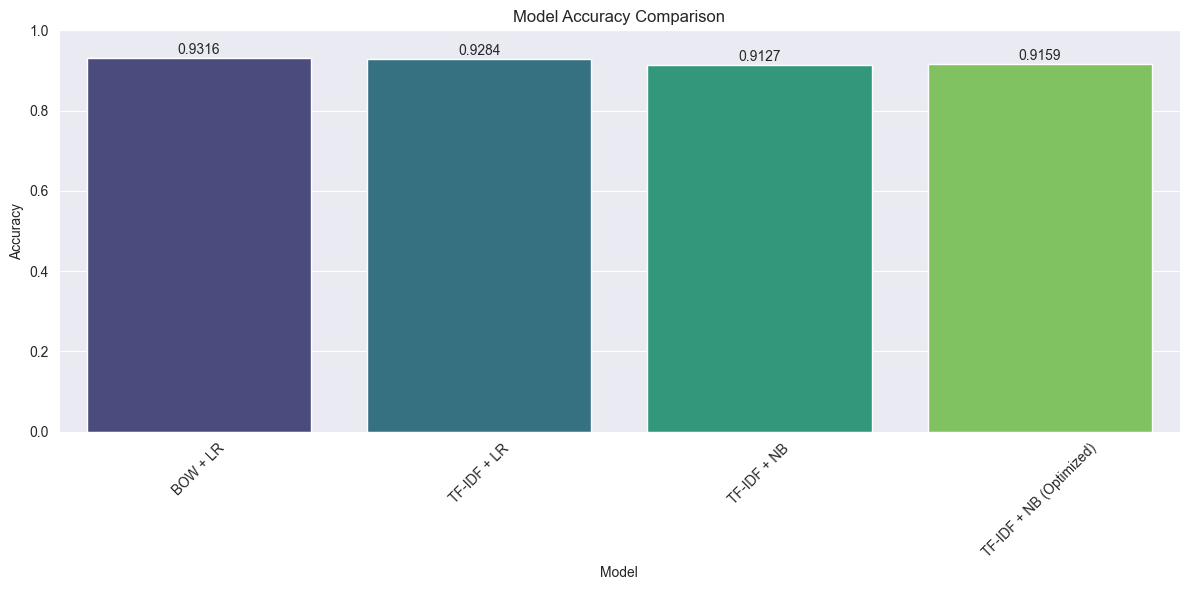

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/1344807246.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1 Score (weighted)', data=comparison_df, palette='plasma')


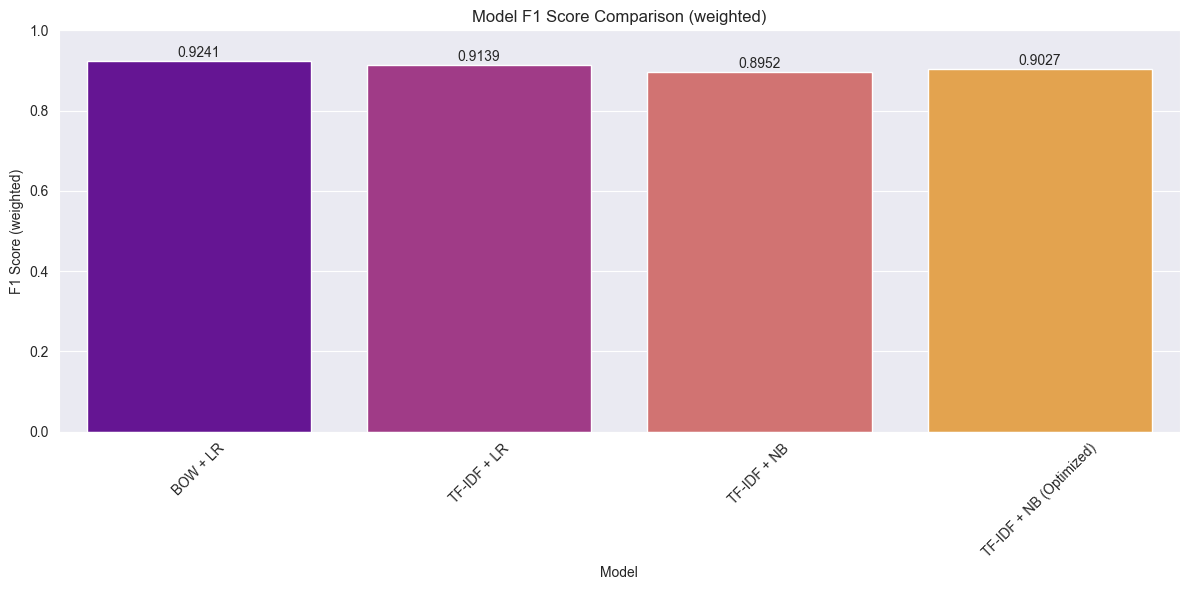

/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/1344807246.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='rocket')


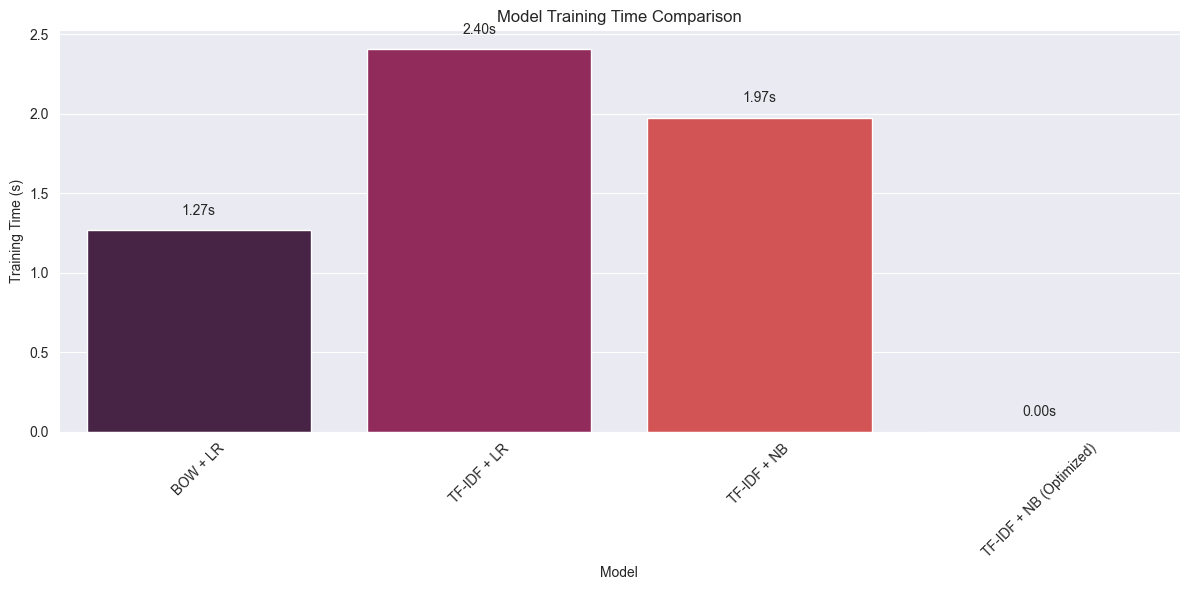

In [81]:
# Compare model performance
models = list(model_results.keys())
accuracies = [model_results[model]['accuracy'] for model in models]
f1_weighted = [model_results[model]['report']['weighted avg']['f1-score'] for model in models]
training_times = [model_results[model].get('training_time', 0) for model in models]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score (weighted)': f1_weighted,
    'Training Time (s)': training_times
})

print("\nModel Performance Comparison:")
print(comparison_df.sort_values('Accuracy', ascending=False))

# Plot accuracy comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Plot F1 score comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score (weighted)', data=comparison_df, palette='plasma')
plt.title('Model F1 Score Comparison (weighted)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
for i, v in enumerate(f1_weighted):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Plot training time comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='rocket')
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
for i, v in enumerate(training_times):
    plt.text(i, v + 0.1, f"{v:.2f}s", ha='center')
plt.tight_layout()
plt.show()


/var/folders/cn/6b40vb1n2537nn1bf2dk2y8h0000gn/T/ipykernel_47706/499083898.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({


<Figure size 1500x1000 with 0 Axes>

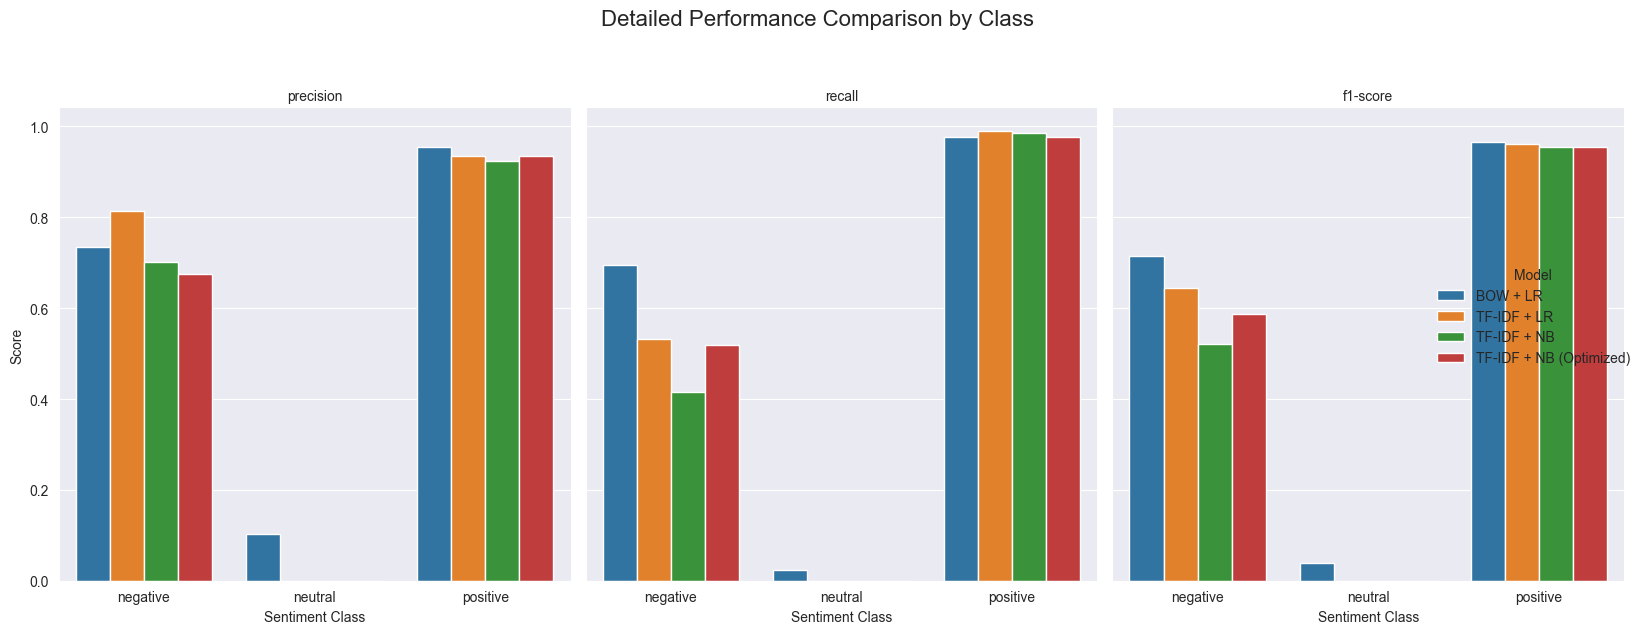

In [82]:
# Detailed class-wise performance comparison
model_metrics = {}
classes = ['negative', 'neutral', 'positive']
metrics = ['precision', 'recall', 'f1-score']

# Extract class-wise metrics for each model
for model_name, results in model_results.items():
    for cls in classes:
        if cls in results['report']:
            for metric in metrics:
                key = f"{model_name}_{cls}_{metric}"
                model_metrics[key] = results['report'][cls][metric]

# Reshape data for visualization
metrics_df = pd.DataFrame(columns=['Model', 'Class', 'Metric', 'Value'])

for model_name in models:
    for cls in classes:
        for metric in metrics:
            key = f"{model_name}_{cls}_{metric}"
            if key in model_metrics:
                metrics_df = pd.concat([metrics_df, pd.DataFrame({
                    'Model': [model_name],
                    'Class': [cls],
                    'Metric': [metric],
                    'Value': [model_metrics[key]]
                })], ignore_index=True)

# Plot detailed comparison
plt.figure(figsize=(15, 10))
g = sns.catplot(
    data=metrics_df, x='Class', y='Value', hue='Model', col='Metric',
    kind='bar', height=6, aspect=0.8, palette='tab10', errorbar=None
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Sentiment Class", "Score")
g.fig.suptitle("Detailed Performance Comparison by Class", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


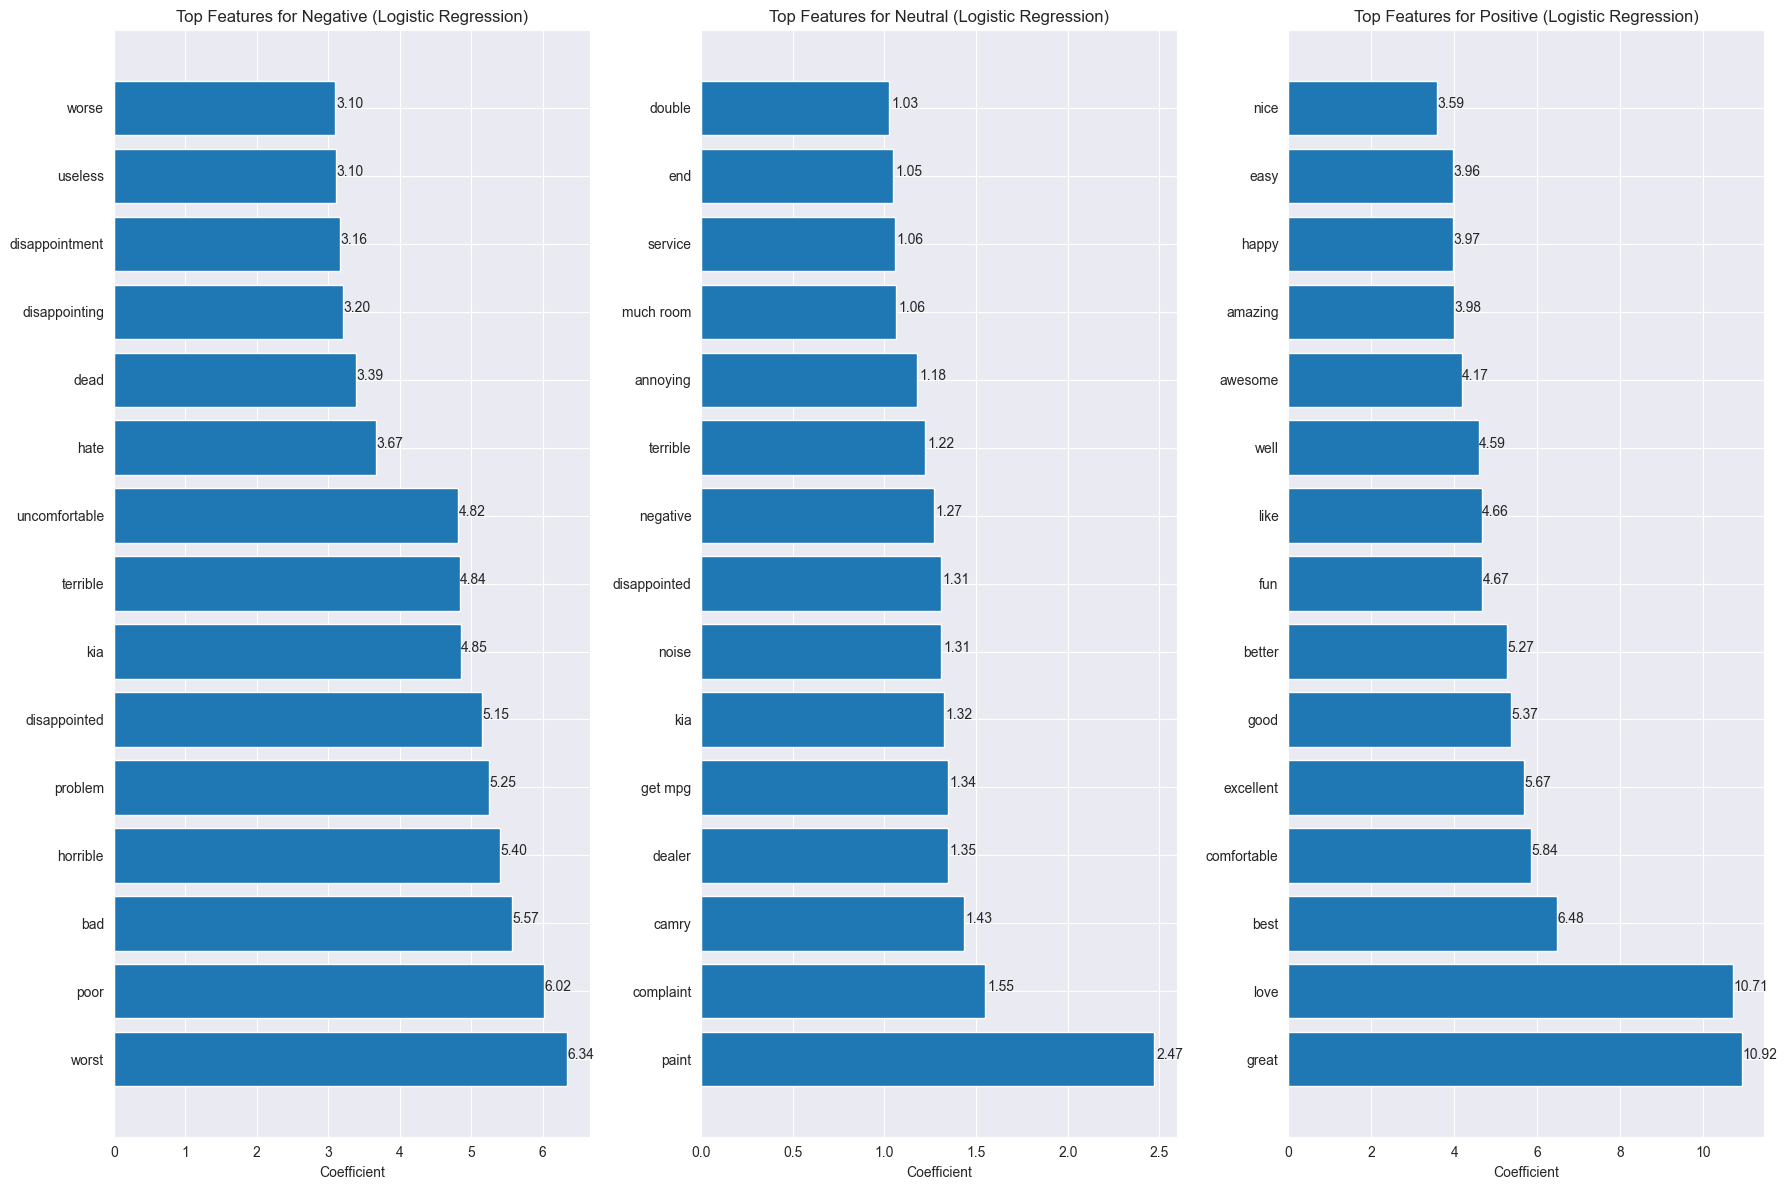

In [83]:
# Feature importance analysis for Logistic Regression
def get_top_lr_features(pipeline, label_index, n=20):
    vectorizer = pipeline.named_steps['vectorizer']
    model = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()

    # Get coefficients for the specified class
    coef = model.coef_[label_index]

    # Get top features for this class
    top_indices = np.argsort(coef)[::-1][:n]
    top_features = [(feature_names[idx], coef[idx]) for idx in top_indices]

    return top_features

# Get feature importance for TF-IDF + LR model
sentiment_indices = {cls: idx for idx, cls in enumerate(tfidf_lr_pipeline.classes_)}
sentiments = ['negative', 'neutral', 'positive']

plt.figure(figsize=(18, 12))
for i, sentiment in enumerate(sentiments):
    idx = sentiment_indices[sentiment]
    top_features = get_top_lr_features(tfidf_lr_pipeline, idx, n=15)

    feature_names = [f[0] for f in top_features]
    coefficients = [f[1] for f in top_features]

    plt.subplot(1, 3, i+1)
    bars = plt.barh(range(len(feature_names)), coefficients, align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('Coefficient')
    plt.title(f'Top Features for {sentiment.capitalize()} (Logistic Regression)')

    for bar_idx, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar_idx, f"{coefficients[bar_idx]:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
# Error analysis: find examples where models disagree
if 'y_pred_tfidf_nb' in locals() and 'y_pred_tfidf_lr' in locals():
    # Find where NB and LR make different predictions
    disagreement_indices = np.where(y_pred_tfidf_nb != y_pred_tfidf_lr)[0]

    if len(disagreement_indices) > 0:
        # Create a DataFrame with the disagreements
        disagreements = pd.DataFrame({
            'Text': X_test.iloc[disagreement_indices].values,
            'True Label': y_test.iloc[disagreement_indices].values,
            'NB Prediction': y_pred_tfidf_nb[disagreement_indices],
            'LR Prediction': y_pred_tfidf_lr[disagreement_indices]
        })

        # Calculate where each model was correct
        disagreements['NB Correct'] = disagreements['NB Prediction'] == disagreements['True Label']
        disagreements['LR Correct'] = disagreements['LR Prediction'] == disagreements['True Label']

        # Print summary
        print("\nDisagreement Analysis:")
        print(f"Total examples where TF-IDF+NB and TF-IDF+LR disagree: {len(disagreements)}")
        print(f"TF-IDF+NB correct but TF-IDF+LR wrong: {sum(disagreements['NB Correct'] & ~disagreements['LR Correct'])}")
        print(f"TF-IDF+LR correct but TF-IDF+NB wrong: {sum(~disagreements['NB Correct'] & disagreements['LR Correct'])}")
        print(f"Both wrong but different predictions: {sum(~disagreements['NB Correct'] & ~disagreements['LR Correct'])}")

        # Print some examples
        print("\nSample disagreements (first 5):")
        for i, (idx, row) in enumerate(disagreements.head(5).iterrows()):
            print(f"\nExample {i+1}:")
            print(f"Text: {row['Text'][:150]}...")
            print(f"True label: {row['True Label']}")
            print(f"NB prediction: {row['NB Prediction']} (Correct: {row['NB Correct']})")
            print(f"LR prediction: {row['LR Prediction']} (Correct: {row['LR Correct']})")
            print("-" * 80)

